In [25]:
import sys
sys.path.append('../src/')
from decoder import predict
import numpy as np
import torch
import scanpy as sc
import pickle
import matplotlib.pyplot as plt
import scprep
import glob
from plotly3d.plot import trajectories


In [26]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [27]:
traj = np.load('../results_final_Dec22/trajectories_T_extreme.npy')
with open('../results_final_Dec22/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
traj_flattened = traj.reshape(-1, 2)
traj_flattened = scaler.inverse_transform(traj_flattened)
traj = traj_flattened.reshape(traj.shape[0], traj.shape[1], -1)
traj = torch.tensor(traj).float()

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning:

Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [28]:
trajectories(traj)

In [29]:
bad_id = traj[-1, :, 0].argmin()
good_id = np.setdiff1d(np.arange(traj.shape[1]), bad_id)
traj = traj[:, good_id, :]
traj_flattened = traj.reshape(-1, 2)

In [30]:
trajectories(traj)


In [31]:
traj_dec = predict(traj_flattened, '../outputs/2024-12-22/15-50-05/checkpoints/epoch=44-step=2655.ckpt', '../outputs/2024-12-22/15-50-05/scalers/x_scaler.pkl')

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../outputs/2024-12-22/15-50-05/checkpoints/epoch=44-step=2655.ckpt`


In [32]:
traj_dec.shape

(1900, 50)

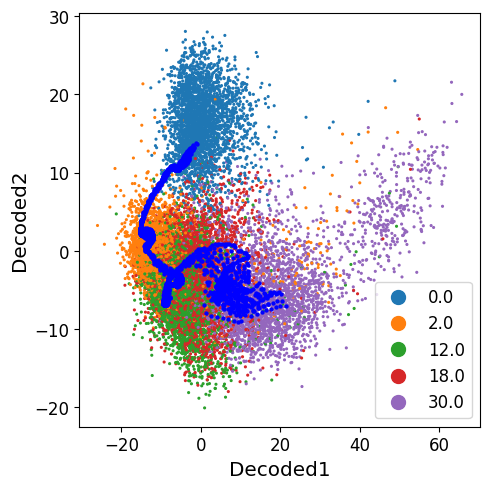

In [33]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
scprep.plot.scatter2d(adata.obsm['X_pca'], c=adata.obs['day'], ticks=True, label_prefix="PCA", ax=ax)
scprep.plot.scatter2d(traj_dec, ticks=True, label_prefix="Decoded", ax=ax, c='b')
plt.tight_layout()
plt.show()

In [34]:
X_recon = (traj_dec @ adata.varm['PCs'].T) + adata.X.toarray().mean(axis=0)

In [35]:
traj_gene_sp = X_recon.reshape(traj.shape[0], traj.shape[1], -1)

In [36]:
np.save('../results_final_Dec22/traj_gene_space_T_extreme.npy', traj_gene_sp)